# <font color="#488000">*Customer Segmentation Classification*</font>

## <font color="#964400">Context</font>


An automobile company has plans to enter new markets with their existing products (P1, P2, P3, P4, and P5). After intensive market research, they’ve deduced that the behavior of the new market is similar to their existing market.

In their existing market, the sales team has classified all customers into 4 segments (A, B, C, D). Then, they performed segmented outreach and communication for a different segment of customers. This strategy has worked exceptionally well for them. They plan to use the same strategy for the new markets and have identified 2627 new potential customers.

You are required to help the manager to predict the right group of the new customers.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import os
import seaborn as sns
import plotly.express as px

In [2]:
# Load Data
filepath = '/kaggle/input/customer-segmentation'

train = pd.read_csv(os.path.join(filepath, 'Train.csv'),index_col='ID')
test = pd.read_csv(os.path.join(filepath, 'Test.csv'),index_col='ID')
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### <font color="#964400">Content</font> 

**Variable** | **Definition**
--- | ---
ID | Unique ID
Gender | Gender of the customer
Ever_Married | Marital status of the customer
Age | Age of the customer
Graduated | Is the customer a graduate?
Profession | Profession of the customer
Work_Experience | Work Experience in years
Spending_Score | Spending score of the customer
Family_Size | Number of family members for the customer (including the customer)
Var_1 | Anonymised Category for the customer
Segmentation | (target) Customer Segment of the customer


In [3]:
def set_frame_style(df, caption=""):
    """Helper function to set dataframe presentation style.
    """
    return df.style.background_gradient(cmap='Greens').set_caption(caption).set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'Green'),
        ('font-size', '18px'),
        ('font-weight','bold')
    ]}])

def check_data(data, title):
    cols = data.columns.to_list()
    display(set_frame_style(data[cols].head(), f'{title}:First Five rows'))
    display(set_frame_style(data[cols].nunique().to_frame().rename({0:'Unique Value Count'}, axis=1).transpose(), f'{title}: Unique Value Counts In Each Column'))
    display(set_frame_style(data[cols].isna().sum().to_frame().transpose(), f'{title}:Columns With Nan'))

In [4]:
check_data(train,"Train Data")

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.000000,Low,4.000000,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,nan,Average,3.000000,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.000000,Low,1.000000,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.000000,High,2.000000,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,nan,High,6.000000,Cat_6,A


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
Unique Value Count,2,2,67,2,9,15,3,9,7,4


,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,0,140,0,78,124,829,0,335,76,0


### <font color="#964400">Replacing NaN values</font>

The following columns contain NaN values:

**Variable** | **Treatment**
--- | ---
Ever_Married | Replace NaN with "No" (assuming "No" means that the customer is not married)
Graduated | Replace NaN with "No" (assuming "No" means that the customer is not graduated)
Profession | Replace NaN with "Not Specified" (unspecified)
Work_Experience | Replace NaN with 0 (zero, indicating that the customer has no work experience)
Family_Size | Replace NaN with the mean of valid values in this column
Var_1 | Replace NaN with "Unknown"


In [5]:
def handle_missing_values(df):
    # Replace NaN in Ever_Married with "No"
    df['Ever_Married'].fillna('No', inplace=True)

    # Replace NaN in Graduated with "No"
    df['Graduated'].fillna('No', inplace=True)

    # Replace NaN in Profession with "Not Specified"
    df['Profession'].fillna('Not Specified', inplace=True)

    # Replace NaN in Work_Experience with 0
    df['Work_Experience'].fillna(0, inplace=True)

    # Replace NaN in Family_Size with the mean of valid values
    mean_family_size = round(df['Family_Size'].mean())
    df['Family_Size'].fillna(mean_family_size, inplace=True)

    # Replace NaN in Var_1 with "Unknown"
    df['Var_1'].fillna('Unknown', inplace=True)

    return df


train = handle_missing_values(train)
train.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
ID,,,,,,,,,,
462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
462643,Female,Yes,38,Yes,Engineer,0.0,Average,3.0,Cat_4,A
466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
462669,Female,Yes,40,Yes,Entertainment,0.0,High,6.0,Cat_6,A


# <font color="#488000">*Exploratory Data Analysis (EDA)*</font>


After completing the necessary data treatments for all columns, we are ready to embark on the Exploratory Data Analysis (EDA) phase. EDA is a critical step in the data analysis process that helps us gain a deeper understanding of the dataset and its underlying patterns. It involves various statistical and visual techniques to explore the data, identify trends, detect anomalies, and generate insights.


## <font color="#964400">Data visualization</font>

In [6]:
def visualize_data(df, column1, column2=None):
    if column2 is None:
        # Create a histogram for a single column
        fig = px.histogram(df, x=column1, title=f'{column1}')
    else:
        # Check if column1 and column2 are numerical
        if pd.api.types.is_numeric_dtype(df[column1]) and pd.api.types.is_numeric_dtype(df[column2]):
            # Create a scatter plot for two numerical columns
            fig = px.scatter(df, x=column1, y=column2, title=f'{column1} vs {column2}')
        else:
            # Create a box plot for a categorical column vs. a numerical column
            fig = px.box(df, x=column1, y=column2, title=f'{column1} vs {column2}')

    # Show the figure
    fig.show()

### <font color="#964400">Histogram 'Age'</font>

- All customers are above 18 years old.
- There is a certain average of customers within each ten-year age range. To simplify, we can create an age range column like 20-30, 31-40, 41-50, etc.

In [7]:
# Histogram of Age
visualize_data(train, 'Age')

In [8]:
import pandas as pd

def create_age_range_column(df):
    # Find the interval limits based on the ages present in the DataFrame
    min_age = df['Age'].min()
    max_age = df['Age'].max()

    # Automatically create intervals based on the minimum and maximum age
    bins = [min_age, 30, 40, 50, 60, 70, max_age]
    
    # Define labels for the intervals
    labels = ['18-30', '31-40', '41-50', '51-60', '61-70', '71+']
    
    # Add the 'age_range' column using cut to map ages to intervals
    df['age_range'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)
    
    return df

train = create_age_range_column(train)

In [9]:
train['age_range'].dtype

CategoricalDtype(categories=['18-30', '31-40', '41-50', '51-60', '61-70', '71+'], ordered=True)

### <font color="#964400">'Age' vs 'Spending_Score'</font>

- It's important to note that the categories 'Low,' 'Average,' and 'High' are well-defined by age. On average, 'Low' is around 35 years old, 'Average' is around 46 years old, and 'High' is around 57.5 years old.


In [10]:
# Scatter Plot of Age vs. Spending_Score
visualize_data(train, 'Age', 'Spending_Score')

### <font color="#964400">'Age' vs 'Var_1'</font>

- Some noticeable differences between 'cat_6' and 'unknown.' In the rest of the categories, patterns seem to follow a similar trend by age.


In [11]:
# Box Plot of Var_1 vs. Age
visualize_data(train, 'Age', 'Var_1')


### <font color="#964400">'Age' vs 'Segmentation'</font>

- It's important to highlight that the segments have visibly different age averages:
  - Segment A: 41 years
  - Segment B: 46 years
  - Segment C: 49 years
  - Segment D: 29 years
- Segments B and C are quite similar in terms of age distribution.

In [12]:
# Box Plot of Segmentation vs. Age
visualize_data(train, 'Age', 'Segmentation')

## <font color="#964400">Label Encoding</font>

In [13]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(df):
    # Separate numeric and categorical columns, excluding the target column
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()

    label_encoder_mappings = {}
    le = LabelEncoder()

    # Encode categorical columns
    for col in cat_cols:
        df[col] = le.fit_transform(df[col])
        label_encoder_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    return df, label_encoder_mappings

train, label_encoder_mappings = encode_categorical_features(train)

## <font color="#964400">Correlation Analysis</font>

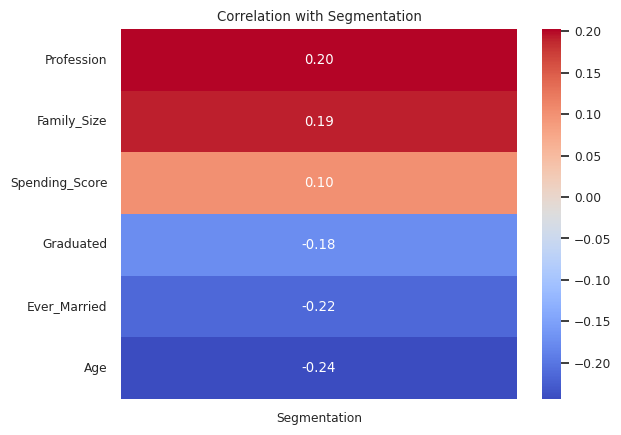

In [14]:
def plot_correlation_heatmap(df, target_column):
    # Calculate correlation matrix for numeric columns
    corr = df.corr(numeric_only=True)
    
    # Calculate correlation with the target column
    target_corr = corr[target_column].drop(target_column)
    
    # Sort correlation values in descending order
    target_corr_sorted = target_corr.sort_values(ascending=False)
    
    # Select features with correlation values greater than or equal to 0.05 in absolute value
    target_corr_filtered = target_corr_sorted[abs(target_corr_sorted) >= 0.05]
    
    # Set the style and palette for the heatmap
    sns.set(font_scale=0.8)
    sns.set_style("white")
    sns.set_palette("PuBuGn_d")
    
    # Create a heatmap with the selected features
    sns.heatmap(target_corr_filtered.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
    plt.title(f'Correlation with {target_column}')
    plt.show()
    
    # Return the DataFrame with the selected features
    return target_corr_filtered.index.tolist()

target_corr_filtered = plot_correlation_heatmap(train, 'Segmentation')